In [3048]:
# In The Name of God - 23/10/1401
# Using P2R UCI trained model to create obfuscated dataset in 2 case:
#   1- aware
#   2- unaware
# Then train utilizer on obfuscated data
# Then evaluate utilizer on raw data and evaluate adversary on obfuscated data

In [3049]:
#@title
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
from collections import OrderedDict
import time

from torch.utils.data import random_split
from math import floor

import torchvision.utils as vutils
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import itertools
import random

import shutil
from zipfile import ZipFile
import os

from IPython.core.debugger import set_trace

import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3050]:
# Hyper parameters:
# change lastRunEpochNumber for every run based on saved files
# For training utilizer:
utl_isFirstRun = True
utl_lastRunEpochNumber = 0
utl_num_epochs = 5 #100

manual_seed = 20

utl_learning_rate = 0.001 #0.2
utl_batch_size = 64

files_not_ready = True
dataset_folder_path = 'drive/MyDrive/ML/datasets'

data_dir = 'adult'
utl_save_dir = 'uci-cont-adv-p2r169-g50-n100'
utl_saving_path = 'drive/MyDrive/ML/saves/' + utl_save_dir + '/'
suffling_train_data_for_utl = True

is_adv = True
if is_adv:
  data_index = 1
else:
  data_index = 2

# Number of workers for dataloader
workers = 2
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

suffling_train_data_for_obf = False
is_aware = False
use_g = True
g_eff_val = -50
miu = 0
coef_for_var = 100

p2r_model_number = 169
p2r_model_path = 'drive/MyDrive/ML/saves/uci-p2r-ae-rev2-model2/'
p2r_batch_size = 64

adv_model_number = 11
adv_model_path = 'drive/MyDrive/ML/saves/uci-adv-rev2-main/'


In [3051]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3052]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3053]:
# download dataset and unzip

if files_not_ready:
    dataset_csv_path = dataset_folder_path + '/adult.csv'

    try:
      os.mkdir(data_dir)
      print("data folder created successfully")
    except OSError as e:
      print("Error: %s" % (e.strerror))

    shutil.copyfile(dataset_csv_path, data_dir + r'/adult.csv')

try:
    os.mkdir(utl_saving_path)
    print("saving_path directory created successfully")
except OSError as e:
    print("Error: %s" % (e.strerror))

Error: File exists
saving_path directory created successfully


In [3054]:
# Define transforms
# train_transforms = transforms.Compose(transforms.ToTensor())
# test_transforms = transforms.Compose(transforms.ToTensor())

In [3055]:
#PreProcess dataset:
df = pd.read_csv(os.path.join(data_dir,'adult.csv'))
df = df.replace({'?':np.nan})
df = df.dropna()
df1 = pd.get_dummies(df)
train, test = train_test_split(df1, test_size = 0.2, random_state = 42)
utility_train_true_labels = np.array(train[['income_<=50K','income_>50K']])
utility_test_true_labels = np.array(test[['income_<=50K','income_>50K']])
private_train_true_labels = np.array(train[['gender_Male', 'gender_Female']])
private_test_true_labels = np.array(test[['gender_Male', 'gender_Female']])
main_x_train_df = (train.drop(['income_<=50K','income_>50K','gender_Male', 'gender_Female'],axis='columns'))
main_x_test_df = (test.drop(['income_<=50K','income_>50K','gender_Male', 'gender_Female'],axis='columns'))
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(main_x_train_df)
main_x_train = standard_scaler.transform(main_x_train_df)
main_x_test = standard_scaler.transform(main_x_test_df)

In [3056]:
from torch.utils.data import Dataset

class UciAdultDataset(Dataset):
    def __init__(self, X, Y_p, Y_u):#, transform):
        self.X = X
        self.Y_p = Y_p
        self.Y_u = Y_u
        # self.transform = transform
        
    def __len__(self):
        return len(self.Y_p)
    
    def __getitem__(self, idx):
        data = self.X[idx]
        label_p = self.Y_p[idx]
        label_u = self.Y_u[idx]
        data = torch.from_numpy(data)
        label_p = torch.from_numpy(label_p)
        label_u = torch.from_numpy(label_u)
        return data, label_p, label_u

In [3057]:
# Load Datas
p2r_train_set = UciAdultDataset(main_x_train, private_train_true_labels, utility_train_true_labels)#, transform=train_transforms)
p2r_test_set = UciAdultDataset(main_x_test, private_test_true_labels, utility_test_true_labels)#, transform=test_transforms)

# DataLoader
p2r_train_loader = torch.utils.data.DataLoader(p2r_train_set, batch_size=p2r_batch_size, shuffle=suffling_train_data_for_obf, num_workers=workers, drop_last=True)
p2r_test_loader = torch.utils.data.DataLoader(p2r_test_set, batch_size=p2r_batch_size, shuffle=suffling_train_data_for_obf, num_workers=workers, drop_last=True)

In [3058]:
# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

In [3059]:
# custom weights initialization called on netG and netD
def weights_init(m):
  classname = m.__class__.__name__
  # print(classname)
  if classname.find('Linear') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [3060]:
# Encoder Model
# class Encoder(nn.Module):
#     def __init__(self, ngpu):
#         super(Encoder, self).__init__()
#         self.ngpu = ngpu
        
#         # input is 102
#         # classifier: (gender)
#         self.fllc1 = nn.Linear(102, 256)
#         self.actv1 = nn.ReLU(inplace=True)
#         self.dropout1 = nn.Dropout(p=0.2) #p=0.5
#         self.fllc2 = nn.Linear(256, 256)
#         self.actv2 = nn.ReLU(inplace=True)
#         self.dropout2 = nn.Dropout(p=0.3) #p=0.5
#         self.fllc3 = nn.Linear(256, 256)
#         self.actv3 = nn.ReLU(inplace=True)
#         #self.dropout3 = nn.Dropout(p=0.5) #p=0.4
#         self.fllc4 = nn.Linear(256, 128)
#         self.actv4 = nn.LogSoftmax(dim=1)

#         # split features: 128 -> 126 + 2 (male/female)
#         # first classifier: (gender)
#         self.fllc_male_features1 = nn.Linear(128, 64)
#         self.actv_male_features1 = nn.ReLU(inplace=True)
#         self.dropout_male_features1 = nn.Dropout(p=0.2) #p=0.2
#         self.fllc_male_features2 = nn.Linear(64, 32)
#         self.actv_male_features2 = nn.ReLU(inplace=True)
#         self.dropout_male_features2 = nn.Dropout(p=0.3) #p=0.3
#         self.fllc_male_features3 = nn.Linear(32, 8)
#         self.actv_male_features3 = nn.ReLU(inplace=True)
#         #self.dropout_male_features3 = nn.Dropout(p=0.5) #p=0.4
#         self.fllc_male_features4 = nn.Linear(8, 2)
#         self.actv_male_features4 = nn.LogSoftmax(dim=1)
#         # other features
#         self.fllc_other_features1 = nn.Linear(128, 128)
#         self.actv_other_features1 = nn.ReLU(inplace=True)
#         self.dropout_other_features1 = nn.Dropout(p=0.2) #p=0.2
#         self.fllc_other_features2 = nn.Linear(128, 128)
#         self.actv_other_features2 = nn.ReLU(inplace=True)
#         self.dropout_other_features2 = nn.Dropout(p=0.3) #p=0.3
#         self.fllc_other_features3 = nn.Linear(128, 128)
#         self.actv_other_features3 = nn.ReLU(inplace=True)
#         #self.dropout_other_features3 = nn.Dropout(p=0.5) #p=0.4
#         self.fllc_other_features4 = nn.Linear(128, 126)
#         self.actv_other_features4 = nn.ReLU(inplace=True)
#         # aggregate features for output

#     def forward(self, x):
#         # Part 1:
#         x = self.fllc1(x)
#         x = self.actv1(x)
#         x = self.dropout1(x)
#         x = self.fllc2(x)
#         x = self.actv2(x)
#         x = self.dropout2(x)
#         x = self.fllc3(x)
#         x = self.actv3(x)
#         # x = self.dropout3(x)
#         x = self.fllc4(x)
#         x = self.actv4(x)
#         # Part 2:
#         # first classifier: (gender)
#         y1 = self.fllc_male_features1(x)
#         y1 = self.actv_male_features1(y1)
#         y1 = self.dropout_male_features1(y1)
#         y1 = self.fllc_male_features2(y1)
#         y1 = self.actv_male_features2(y1)
#         y1 = self.dropout_male_features2(y1)
#         y1 = self.fllc_male_features3(y1)
#         y1 = self.actv_male_features3(y1)
#         # y1 = self.dropout_male_features3(y1)
#         y1 = self.fllc_male_features4(y1)
#         y1 = self.actv_male_features4(y1)
#         # other features
#         y3 = self.fllc_other_features1(x) 
#         y3 = self.actv_other_features1(y3)
#         y3 = self.dropout_other_features1(y3)
#         y3 = self.fllc_other_features2(y3) 
#         y3 = self.actv_other_features2(y3)
#         y3 = self.dropout_other_features2(y3)
#         y3 = self.fllc_other_features3(y3) 
#         y3 = self.actv_other_features3(y3)
#         # y3 = self.dropout_other_features3(y3)
#         y3 = self.fllc_other_features4(y3)
#         y3 = self.actv_other_features4(y3)
#         return y1, y3
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        
        # input is 102
        self.fllc1 = nn.Linear(102, 128)
        self.actv1 = nn.ReLU(inplace=True)
        # self.dropout1 = nn.Dropout(p=0.2) #p=0.5
        self.fllc2 = nn.Linear(128, 128)
        self.actv2 = nn.ReLU(inplace=True)
        # self.dropout2 = nn.Dropout(p=0.3) #p=0.5
        # self.fllc3 = nn.Linear(256, 256)
        # self.actv3 = nn.ReLU(inplace=True)
        #self.dropout3 = nn.Dropout(p=0.5) #p=0.4
        self.fllc4 = nn.Linear(128, 64)
        self.actv4 = nn.ReLU(inplace=True)

        # split features: 128 -> 126 + 2 (male/female)
        # first classifier: (gender)
        # self.fllc_male_features1 = nn.Linear(128, 64)
        # self.actv_male_features1 = nn.ReLU(inplace=True)
        # self.dropout_male_features1 = nn.Dropout(p=0.2) #p=0.2
        self.fllc_male_features2 = nn.Linear(64, 32)
        self.actv_male_features2 = nn.ReLU(inplace=True)
        # self.dropout_male_features2 = nn.Dropout(p=0.3) #p=0.3
        self.fllc_male_features3 = nn.Linear(32, 8)
        self.actv_male_features3 = nn.ReLU(inplace=True)
        #self.dropout_male_features3 = nn.Dropout(p=0.5) #p=0.4
        self.fllc_male_features4 = nn.Linear(8, 2)
        self.actv_male_features4 = nn.LogSoftmax(dim=1)
        # other features
        self.fllc_other_features1 = nn.Linear(64, 64)
        self.actv_other_features1 = nn.ReLU(inplace=True)
        # self.dropout_other_features1 = nn.Dropout(p=0.2) #p=0.2
        self.fllc_other_features2 = nn.Linear(64, 62)
        self.actv_other_features2 = nn.ReLU(inplace=True)
        # self.dropout_other_features2 = nn.Dropout(p=0.3) #p=0.3
        # self.fllc_other_features3 = nn.Linear(128, 128)
        # self.actv_other_features3 = nn.ReLU(inplace=True)
        #self.dropout_other_features3 = nn.Dropout(p=0.5) #p=0.4
        # self.fllc_other_features4 = nn.Linear(128, 126)
        # self.actv_other_features4 = nn.ReLU(inplace=True)
        # aggregate features for output

    def forward(self, x):
        # Part 1:
        x = self.fllc1(x)
        x = self.actv1(x)
        # x = self.dropout1(x)
        x = self.fllc2(x)
        x = self.actv2(x)
        # x = self.dropout2(x)
        # x = self.fllc3(x)
        # x = self.actv3(x)
        # x = self.dropout3(x)
        x = self.fllc4(x)
        x = self.actv4(x)
        # Part 2:
        # first classifier: (gender)
        # y1 = self.fllc_male_features1(x)
        # y1 = self.actv_male_features1(y1)
        # y1 = self.dropout_male_features1(y1)
        y1 = self.fllc_male_features2(x)
        y1 = self.actv_male_features2(y1)
        # y1 = self.dropout_male_features2(y1)
        y1 = self.fllc_male_features3(y1)
        y1 = self.actv_male_features3(y1)
        # y1 = self.dropout_male_features3(y1)
        y1 = self.fllc_male_features4(y1)
        y1 = self.actv_male_features4(y1)
        # other features
        y3 = self.fllc_other_features1(x) 
        y3 = self.actv_other_features1(y3)
        # y3 = self.dropout_other_features1(y3)
        y3 = self.fllc_other_features2(y3) 
        y3 = self.actv_other_features2(y3)
        # y3 = self.dropout_other_features2(y3)
        # y3 = self.fllc_other_features3(y3) 
        # y3 = self.actv_other_features3(y3)
        # y3 = self.dropout_other_features3(y3)
        # y3 = self.fllc_other_features4(y3)
        # y3 = self.actv_other_features4(y3)
        return y1, y3

In [3061]:
# Decoder Model
# class Decoder(nn.Module):
#     def __init__(self, ngpu):
#         super(Decoder, self).__init__()
#         self.ngpu = ngpu
        
#         # input size is 64
#         self.fllc1 = nn.Linear(128, 256)
#         self.actv1 = nn.ReLU(inplace=True)
#         self.dropout1 = nn.Dropout(p=0.2) #p=0.5
#         self.fllc2 = nn.Linear(256, 256)
#         self.actv2 = nn.ReLU(inplace=True)
#         self.dropout2 = nn.Dropout(p=0.3) #p=0.5
#         self.fllc3 = nn.Linear(256, 256)
#         self.actv3 = nn.ReLU(inplace=True)
#         # self.dropout3 = nn.Dropout(p=0.5) #p=0.4
#         self.fllc4 = nn.Linear(256, 102)
#         self.actv4 = nn.Tanh()

#     def forward(self, x):
#         x = self.fllc1(x)
#         x = self.actv1(x)
#         x = self.dropout1(x)
#         x = self.fllc2(x)
#         x = self.actv2(x)
#         x = self.dropout2(x)
#         x = self.fllc3(x)
#         x = self.actv3(x)
#         # x = self.dropout3(x)
#         x = self.fllc4(x)
#         x = self.actv4(x)
#         return x
class Decoder(nn.Module):
    def __init__(self, ngpu):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        
        # input size is 64
        self.fllc1 = nn.Linear(64, 128)
        self.actv1 = nn.ReLU(inplace=True)
        # self.dropout1 = nn.Dropout(p=0.2) #p=0.5
        self.fllc2 = nn.Linear(128, 128)
        self.actv2 = nn.ReLU(inplace=True)
        # self.dropout2 = nn.Dropout(p=0.3) #p=0.5
        # self.fllc3 = nn.Linear(256, 256)
        # self.actv3 = nn.ReLU(inplace=True)
        # self.dropout3 = nn.Dropout(p=0.5) #p=0.4
        self.fllc4 = nn.Linear(128, 102)
        self.actv4 = nn.Sigmoid()

    def forward(self, x):
        x = self.fllc1(x)
        x = self.actv1(x)
        # x = self.dropout1(x)
        x = self.fllc2(x)
        x = self.actv2(x)
        # x = self.dropout2(x)
        # x = self.fllc3(x)
        # x = self.actv3(x)
        # x = self.dropout3(x)
        x = self.fllc4(x)
        x = self.actv4(x)
        return x

In [3062]:
# AE Model
class AEModel(nn.Module):
    def __init__(self, ngpu, mode='train', miu=0, coef_for_var=1, g_eff_val=-3000):
        super(AEModel, self).__init__()
        self.ngpu = ngpu
        self.g_eff_val = g_eff_val
        self.miu = miu
        self.coef_for_var = coef_for_var
        self.mode = mode
        self.encoder = Encoder(ngpu).to(device)
        self.decoder = Decoder(ngpu).to(device)

    def tune_noise(self, miu=0, coef_for_var=1, g_eff_val=-3000):
        self.miu = miu
        self.coef_for_var = coef_for_var
        self.g_eff_val = g_eff_val

    def change_mode(self, mode='train'):
        self.mode = mode

    def add_noise(self, nodes):
      with torch.no_grad():
        var = (self.coef_for_var) * (torch.mean(nodes).item())
        noise = self.miu + (var) * torch.randn(nodes.size())
        noise = noise.to(device)
        nodes.add_(noise)
        return nodes

    def change_lbl(self, nodes, lbls):
      with torch.no_grad():
        lbls[lbls == 0] = self.g_eff_val
        lbls[lbls == 1] = 0
        nodes = lbls
        return nodes

    def forward(self, x, y1_real_lbl=[]):
        y1, y3 = self.encoder(x)
        if self.mode=='use':
            if use_g:
              # y1 = y1_real_lbl
              y1 = self.change_lbl(y1, y1_real_lbl)
            y3 = self.add_noise(y3)
        y = torch.cat((y1, y3), 1)
        x = self.decoder(y)
        return x, y1

In [3063]:
# Create the AE
netAE = AEModel(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netAE = nn.DataParallel(netAE, list(range(ngpu)))

In [3064]:
# Function - Save:
def save_model(saving_path, name, number, model, res):
  checkpoint = {'res': res,
                'state_dict': model.state_dict()}
  torch.save(checkpoint, saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth')
  return True

In [3065]:
# Function - Load:
def load_model(saving_path, name, number, model, device):
  
  checkpoint = torch.load(saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth', map_location=device)
  res = checkpoint['res']
  model.load_state_dict(checkpoint['state_dict'])
  return {'model':model,
          'res':res}

In [3066]:
# Function - Delete file:
def delete_file(saving_path, name, number):
  address = saving_path + 'checkpoint-' + name + '-' + str(number) + '.pth'
  try:
    os.remove(address)
    print("old file removed successfully")
  except OSError as e:
    print("Error: %s" % (e.strerror))

In [3067]:
# Load p2r model:
ae_load = load_model(p2r_model_path, 'ae', p2r_model_number, netAE, device)

In [3068]:
def extract_class_index(labels):
  return labels[:,0]

In [3069]:
def extract_two_value_labels(labels):
  # return labels
  new_labels = torch.stack([labels[:,1],labels[:,0]],dim=1)
  return new_labels

In [3070]:
def convert_dataset(my_loader, modified_x):
    prog_bar = tqdm(enumerate(my_loader), total=len(my_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[2]
            # added:
            labels = extract_two_value_labels(labels)
            inputs, labels = inputs.to(torch.float32), labels.to(torch.float32)
            # inputs = inputs.to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)
            output, y1 = netAE.forward(inputs, labels)
            first = i*p2r_batch_size
            second = (i+1)*p2r_batch_size-1
            modified_x[first : second+1][:] = output.to('cpu')

In [3071]:
def one_hot_encode_tensor(my_tensor):
  max_idx = torch.argmax(my_tensor, 1, keepdim=True)
  one_hot = torch.FloatTensor(my_tensor.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot

In [3072]:
def one_hot_encode_df(df):
  others_t = torch.tensor(df[["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]].values)
  workclass_t = torch.tensor(df[["workclass_Federal-gov", "workclass_Local-gov", "workclass_Private", "workclass_Self-emp-inc", "workclass_Self-emp-not-inc", "workclass_State-gov", "workclass_Without-pay"]].values)
  education_t = torch.tensor(df[["education_10th", "education_11th", "education_12th", "education_1st-4th", "education_5th-6th", "education_7th-8th", "education_9th", "education_Assoc-acdm", "education_Assoc-voc", "education_Bachelors", "education_Doctorate", "education_HS-grad", "education_Masters", "education_Preschool", "education_Prof-school", "education_Some-college"]].values)
  marital_t = torch.tensor(df[["marital-status_Divorced", "marital-status_Married-AF-spouse", "marital-status_Married-civ-spouse", "marital-status_Married-spouse-absent", "marital-status_Never-married", "marital-status_Separated", "marital-status_Widowed"]].values)
  occupation_t = torch.tensor(df[["occupation_Adm-clerical", "occupation_Armed-Forces", "occupation_Craft-repair", "occupation_Exec-managerial", "occupation_Farming-fishing", "occupation_Handlers-cleaners", "occupation_Machine-op-inspct", "occupation_Other-service", "occupation_Priv-house-serv", "occupation_Prof-specialty", "occupation_Protective-serv", "occupation_Sales", "occupation_Tech-support", "occupation_Transport-moving"]].values)
  relationship_t = torch.tensor(df[["relationship_Husband", "relationship_Not-in-family", "relationship_Other-relative", "relationship_Own-child", "relationship_Unmarried", "relationship_Wife"]].values)
  race_t = torch.tensor(df[["race_Amer-Indian-Eskimo", "race_Asian-Pac-Islander", "race_Black", "race_Other", "race_White"]].values)
  # gender_t = torch.tensor(df[["gender_Female", "gender_Male"]].values)
  country_t = torch.tensor(df[["native-country_Cambodia", "native-country_Canada", "native-country_China", "native-country_Columbia", "native-country_Cuba", "native-country_Dominican-Republic", "native-country_Ecuador", "native-country_El-Salvador", "native-country_England", "native-country_France", "native-country_Germany", "native-country_Greece", "native-country_Guatemala", "native-country_Haiti", "native-country_Holand-Netherlands", "native-country_Honduras", "native-country_Hong", "native-country_Hungary", "native-country_India", "native-country_Iran", "native-country_Ireland", "native-country_Italy", "native-country_Jamaica", "native-country_Japan", "native-country_Laos", "native-country_Mexico", "native-country_Nicaragua", "native-country_Outlying-US(Guam-USVI-etc)", "native-country_Peru", "native-country_Philippines", "native-country_Poland", "native-country_Portugal", "native-country_Puerto-Rico", "native-country_Scotland", "native-country_South", "native-country_Taiwan", "native-country_Thailand", "native-country_Trinadad&Tobago", "native-country_United-States", "native-country_Vietnam", "native-country_Yugoslavia"]].values)
  # income_t = torch.tensor(df[["income_<=50K", "income_>50K"]].values)
  
  # others_oh       = one_hot_encode_tensor(others_t)
  workclass_oh    = one_hot_encode_tensor(workclass_t)
  education_oh    = one_hot_encode_tensor(education_t)
  marital_oh      = one_hot_encode_tensor(marital_t)
  occupation_oh   = one_hot_encode_tensor(occupation_t)
  relationship_oh = one_hot_encode_tensor(relationship_t)
  race_oh         = one_hot_encode_tensor(race_t)
  # gender_oh       = one_hot_encode_tensor(gender_t)
  country_oh      = one_hot_encode_tensor(country_t)
  # income_oh       = one_hot_encode_tensor(income_t)

  # final_tensor = torch.cat([others_t, workclass_oh, education_oh, marital_oh, occupation_oh, relationship_oh, race_oh, gender_oh, country_oh, income_oh], dim=1)
  final_tensor = torch.cat([others_t, workclass_oh, education_oh, marital_oh, occupation_oh, relationship_oh, race_oh, country_oh], dim=1)
  # final_df = pd.DataFrame(final_tensor.numpy(), columns=["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week", "workclass_Federal-gov", "workclass_Local-gov", "workclass_Private", "workclass_Self-emp-inc", "workclass_Self-emp-not-inc", "workclass_State-gov", "workclass_Without-pay", "education_10th", "education_11th", "education_12th", "education_1st-4th", "education_5th-6th", "education_7th-8th", "education_9th", "education_Assoc-acdm", "education_Assoc-voc", "education_Bachelors", "education_Doctorate", "education_HS-grad", "education_Masters", "education_Preschool", "education_Prof-school", "education_Some-college", "marital-status_Divorced", "marital-status_Married-AF-spouse", "marital-status_Married-civ-spouse", "marital-status_Married-spouse-absent", "marital-status_Never-married", "marital-status_Separated", "marital-status_Widowed", "occupation_Adm-clerical", "occupation_Armed-Forces", "occupation_Craft-repair", "occupation_Exec-managerial", "occupation_Farming-fishing", "occupation_Handlers-cleaners", "occupation_Machine-op-inspct", "occupation_Other-service", "occupation_Priv-house-serv", "occupation_Prof-specialty", "occupation_Protective-serv", "occupation_Sales", "occupation_Tech-support", "occupation_Transport-moving", "relationship_Husband", "relationship_Not-in-family", "relationship_Other-relative", "relationship_Own-child", "relationship_Unmarried", "relationship_Wife", "race_Amer-Indian-Eskimo", "race_Asian-Pac-Islander", "race_Black", "race_Other", "race_White", "gender_Female", "gender_Male", "native-country_Cambodia", "native-country_Canada", "native-country_China", "native-country_Columbia", "native-country_Cuba", "native-country_Dominican-Republic", "native-country_Ecuador", "native-country_El-Salvador", "native-country_England", "native-country_France", "native-country_Germany", "native-country_Greece", "native-country_Guatemala", "native-country_Haiti", "native-country_Holand-Netherlands", "native-country_Honduras", "native-country_Hong", "native-country_Hungary", "native-country_India", "native-country_Iran", "native-country_Ireland", "native-country_Italy", "native-country_Jamaica", "native-country_Japan", "native-country_Laos", "native-country_Mexico", "native-country_Nicaragua", "native-country_Outlying-US(Guam-USVI-etc)", "native-country_Peru", "native-country_Philippines", "native-country_Poland", "native-country_Portugal", "native-country_Puerto-Rico", "native-country_Scotland", "native-country_South", "native-country_Taiwan", "native-country_Thailand", "native-country_Trinadad&Tobago", "native-country_United-States", "native-country_Vietnam", "native-country_Yugoslavia", "income_<=50K", "income_>50K"])
  final_df = pd.DataFrame(data=final_tensor.numpy(), index=df.index, columns=df.columns)
  return final_df

In [3073]:
def reconst_by_awareness(modified_x, main_x_df):
  modified_x_inverse = standard_scaler.inverse_transform(modified_x)
  modified_x_inverse_df = pd.DataFrame(data = modified_x_inverse, 
                  index = main_x_df.index, 
                  columns = main_x_df.columns)
  
  # for col in modified_x_inverse_df.columns:
  #   if (col != 'age') & (col != 'fnlwgt') & (col != 'educational-num') & (col != 'capital-gain') & (col != 'capital-loss') & (col != 'hours-per-week'):
  #     for i in modified_x_inverse_df.index:
  #       if modified_x_inverse_df.at[i,col] >= 0.5:
  #         modified_x_inverse_df.at[i,col] = 1
  #       else:
  #         modified_x_inverse_df.at[i,col] = 0

  modified_x_inverse_df = one_hot_encode_df(modified_x_inverse_df)

  standard_scaler2 = preprocessing.StandardScaler()
  standard_scaler2.fit(modified_x_inverse_df)
  modified_x = standard_scaler2.transform(modified_x_inverse_df)


In [3074]:
# using model to convert public to reference dataset 
# using: y1 (gender) - replace by real label
#        y3 (others) - adding noise - N(0,1)
modified_x_train = np.zeros(main_x_train.shape)
modified_x_test = np.zeros(main_x_test.shape)

netAE.change_mode('use')
netAE.eval()
netAE.tune_noise(miu, coef_for_var, g_eff_val)
print("Converting train records...\n")
convert_dataset(p2r_train_loader, modified_x_train)
if is_aware:
  reconst_by_awareness(modified_x_train, main_x_train_df)
print("\nConverting test records...")
convert_dataset(p2r_test_loader, modified_x_test)
if is_aware:
  reconst_by_awareness(modified_x_test, main_x_test_df)

Converting train records...



100%|██████████| 565/565 [00:02<00:00, 265.20it/s]


Converting test records...



100%|██████████| 141/141 [00:00<00:00, 245.16it/s]


In [3075]:
# Load Datas
utl_train_set = UciAdultDataset(modified_x_train, private_train_true_labels, utility_train_true_labels)#, transform=train_transforms)
utl_test_set = UciAdultDataset(modified_x_test, private_test_true_labels, utility_test_true_labels)#, transform=test_transforms)

# DataLoader
utl_train_loader = torch.utils.data.DataLoader(utl_train_set, batch_size=utl_batch_size, shuffle=suffling_train_data_for_utl, num_workers=workers, drop_last=True)
utl_test_loader = torch.utils.data.DataLoader(utl_test_set, batch_size=utl_batch_size, shuffle=suffling_train_data_for_utl, num_workers=workers, drop_last=True)

In [3076]:
# Utilizer Model
class UtlModel(nn.Module):
    def __init__(self, ngpu):
        super(UtlModel, self).__init__()
        self.ngpu = ngpu
        
        # input is 102
        # classifier: (gender)
        self.fllc1 = nn.Linear(102, 256)
        self.actv1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fllc2 = nn.Linear(256, 256)
        self.actv2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fllc3 = nn.Linear(256, 128)
        self.actv3 = nn.ReLU(inplace=True)
        self.dropout3 = nn.Dropout(p=0.4)
        self.fllc4 = nn.Linear(128, 2)
        self.actv4 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        y1 = self.fllc1(x)
        y1 = self.actv1(y1)
        y1 = self.dropout1(y1)
        y1 = self.fllc2(y1)
        y1 = self.actv2(y1)
        y1 = self.dropout2(y1)
        y1 = self.fllc3(y1)
        y1 = self.actv3(y1)
        y1 = self.dropout3(y1)
        y1 = self.fllc4(y1)
        y1 = self.actv4(y1)
        return y1


In [3077]:
# Create the Utl
utilizerModel = UtlModel(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    utilizerModel = nn.DataParallel(utilizerModel, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
utilizerModel.apply(weights_init)

UtlModel(
  (fllc1): Linear(in_features=102, out_features=256, bias=True)
  (actv1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fllc2): Linear(in_features=256, out_features=256, bias=True)
  (actv2): ReLU(inplace=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fllc3): Linear(in_features=256, out_features=128, bias=True)
  (actv3): ReLU(inplace=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fllc4): Linear(in_features=128, out_features=2, bias=True)
  (actv4): LogSoftmax(dim=1)
)

In [3078]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in utilizerModel.parameters())
print(f"{total_params:,} training parameters.")

125,314 training parameters.


In [3079]:
utilizerCriterion = nn.NLLLoss() # nn.BCELoss() # nn.MSELoss()
utilizerOptimizer = optim.Adam(utilizerModel.parameters(), lr=utl_learning_rate, betas=(beta1, 0.999))

In [3080]:
# Save Start Checkpoint

if(utl_isFirstRun):
  utl_res = {'train_losses': [],
             'valid_losses': [],
             'test_y1_acc': [],
             'epoch_number': 0,
           };
  save_model(utl_saving_path, 'utl', 0, utilizerModel, utl_res)

In [3081]:
# Load Last Checkpoint:
utl_load = load_model(utl_saving_path, 'utl', utl_lastRunEpochNumber, utilizerModel, device)

train_losses = utl_load['res']['train_losses']
valid_losses = utl_load['res']['valid_losses']
test_y1_acc = utl_load['res']['test_y1_acc']
last_epoch = utl_load['res']['epoch_number']

In [3082]:
# Function - training function
def fit(model, train_loader, optimizer, criterion):
    model.train()

    train_loss = 0.0
    prog_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, data in prog_bar:
        inputs, labels = data[0], data[data_index]
        # added:
        labels = extract_class_index(labels)
        # inputs, labels = inputs.to(torch.float64), labels.to(torch.float32)
        inputs = inputs.to(torch.float32)
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()          
    train_loss = train_loss / len(train_loader)
    return train_loss

In [3083]:
# Function - validation function
def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    prog_bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[data_index]
            # added:
            labels = extract_class_index(labels)
            # inputs, labels = inputs.to(torch.float64), labels.to(torch.float32)
            inputs = inputs.to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
        valid_loss = valid_loss / len(valid_loader)
        return valid_loss

In [3084]:
# Calc Accuracy
def calcAccuracyTest(model, test_loader):
    print('Testing')
    model.to(device)
    model.eval()
    y1_accuracy = 0
    prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[data_index]
            # added:
            labels = extract_class_index(labels)
            # inputs, labels = inputs.to(torch.float32), labels.to(torch.float32)
            inputs = inputs.to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)
            # a1, label_top_class = labels.topk(1, dim=1)
            output = model(inputs)
            ps_y1 = torch.exp(output)
            top_p_y1, top_class_y1 = ps_y1.topk(1, dim=1)
            # equals_y1 = top_class_y1 == label_top_class.view(*top_class_y1.shape)
            equals_y1 = top_class_y1 == labels.view(*top_class_y1.shape)
            acc_y1 = equals_y1.sum().item()
            y1_accuracy += (acc_y1 / len(equals_y1))            
    y1_accuracy = y1_accuracy / len(test_loader)
    return y1_accuracy

In [3085]:
# for test:

# is_aware = False
# use_g = True
# g_eff_val = -50
# miu = 0
# coef_for_var = 30
# utl1_model_number = 8
# utl1_model_path = 'drive/MyDrive/ML/saves/uci-utl-rev2-main/'

# # using model to convert public to reference dataset 
# # using: y1 (gender) - replace by real label
# #        y3 (others) - adding noise - N(0,1)
# modified_x_train = np.zeros(main_x_train.shape)
# modified_x_test = np.zeros(main_x_test.shape)

# netAE.change_mode('use')
# netAE.eval()
# netAE.tune_noise(miu, coef_for_var, g_eff_val)
# print("Converting train records...\n")
# convert_dataset(p2r_train_loader, modified_x_train)
# if is_aware:
#   reconst_by_awareness(modified_x_train, main_x_train_df)
# print("\nConverting test records...")
# convert_dataset(p2r_test_loader, modified_x_test)
# if is_aware:
#   reconst_by_awareness(modified_x_test, main_x_test_df)

# # Load Datas
# utl_train_set = UciAdultDataset(modified_x_train, private_train_true_labels, utility_train_true_labels)#, transform=train_transforms)
# utl_test_set = UciAdultDataset(modified_x_test, private_test_true_labels, utility_test_true_labels)#, transform=test_transforms)

# # DataLoader
# utl_train_loader = torch.utils.data.DataLoader(utl_train_set, batch_size=utl_batch_size, shuffle=suffling_train_data_for_utl, num_workers=workers, drop_last=True)
# utl_test_loader = torch.utils.data.DataLoader(utl_test_set, batch_size=utl_batch_size, shuffle=suffling_train_data_for_utl, num_workers=workers, drop_last=True)

# utilizerModel1 = UtlModel(ngpu).to(device)
# if (device.type == 'cuda') and (ngpu > 1):
#     utilizerModel1 = nn.DataParallel(utilizerModel1, list(range(ngpu)))
# utl_load1 = load_model(utl1_model_path, 'adv', utl1_model_number, utilizerModel1, device)
# utilizerModel1.to(device)
# income_accuracy = calcAccuracyTest(utilizerModel1, utl_test_loader)
# print(f"\n Utilizer Income Accuracy on Testset: {income_accuracy:.10f}")

# gender_accuracy = calcAdvAccuracyTest(adversaryModel, utl_test_loader)
# print(f"\n Adversary Gender Accuracy on Testset: {gender_accuracy:.6f}")

In [3086]:
# Training Loop
utilizerModel.to(device)
calc_every_epoch = 1
save_every_epoch = 1

if is_adv:
  here_test_loader = utl_test_loader
else:
  here_test_loader = p2r_test_loader

start = time.time()
print("Starting Training Loop...")

for epoch in range(last_epoch+1, utl_num_epochs+1):
    print(f"Epoch {epoch}/{utl_num_epochs}: ")
    train_loss = fit(utilizerModel, utl_train_loader, utilizerOptimizer, utilizerCriterion)
    valid_loss = validate(utilizerModel, utl_test_loader, utilizerCriterion)
    y1_accuracy = calcAccuracyTest(utilizerModel, here_test_loader)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_y1_acc.append(y1_accuracy)

    utl_res = {'train_losses': train_losses,
               'valid_losses': valid_losses,
               'test_y1_acc': test_y1_acc,
               'epoch_number': epoch
                }
    save_model(utl_saving_path, 'utl', 'last', utilizerModel, utl_res)
    if epoch % save_every_epoch == 0:
        save_model(utl_saving_path, 'utl', epoch, utilizerModel, utl_res)
    if epoch % calc_every_epoch == 0:
        print(f"\nTrain Loss: {train_loss:.6f}")
        print(f"Valid Loss: {valid_loss:.6f}")
        print(f"Accuracy on Testset: {y1_accuracy:.6f}")

end = time.time()
print(f"\nTraining time: {(end-start)/60:.3f} minutes")

print('TRAINING COMPLETE')

Starting Training Loop...
Epoch 1/5: 


100%|██████████| 141/141 [00:00<00:00, 201.62it/s]

Testing



100%|██████████| 141/141 [00:00<00:00, 192.96it/s]


Train Loss: 0.635170
Valid Loss: 0.631242
Accuracy on Testset: 0.676529
Epoch 2/5: 



100%|██████████| 141/141 [00:00<00:00, 306.44it/s]

Testing



100%|██████████| 141/141 [00:00<00:00, 286.21it/s]



Train Loss: 0.632421
Valid Loss: 0.630562
Accuracy on Testset: 0.676973
Epoch 3/5: 


100%|██████████| 141/141 [00:00<00:00, 282.64it/s]

Testing



100%|██████████| 141/141 [00:00<00:00, 280.95it/s]



Train Loss: 0.631681
Valid Loss: 0.629989
Accuracy on Testset: 0.676418
Epoch 4/5: 


100%|██████████| 141/141 [00:00<00:00, 182.70it/s]

Testing



100%|██████████| 141/141 [00:00<00:00, 160.09it/s]


Train Loss: 0.631268
Valid Loss: 0.630002
Accuracy on Testset: 0.676973
Epoch 5/5: 



100%|██████████| 141/141 [00:00<00:00, 304.96it/s]

Testing



100%|██████████| 141/141 [00:00<00:00, 286.58it/s]



Train Loss: 0.630901
Valid Loss: 0.630064
Accuracy on Testset: 0.676418

Training time: 0.409 minutes
TRAINING COMPLETE


Loss plot...


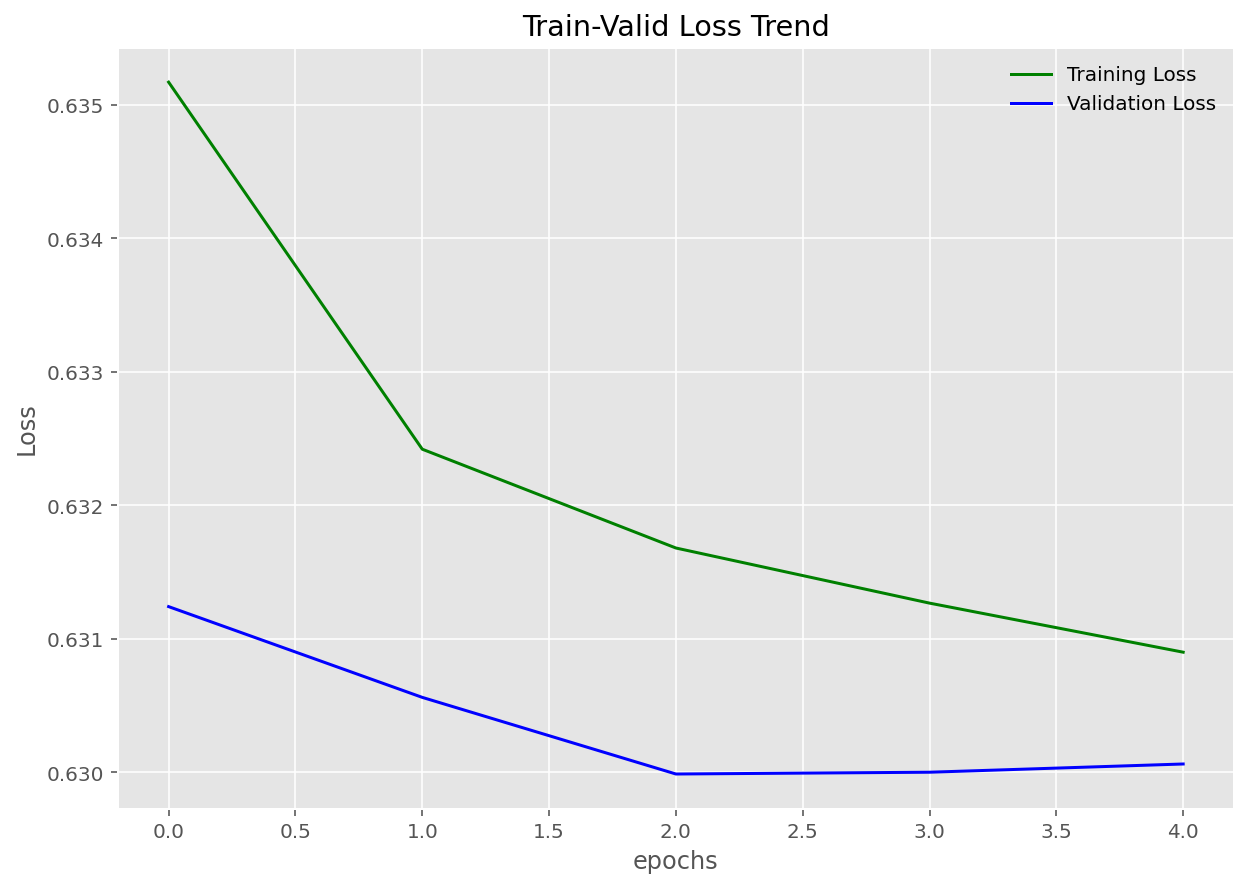

In [3087]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('Loss plot...')

# loss plots
plt.figure(figsize=(10,7))
plt.title("Train-Valid Loss Trend")
plt.plot(train_losses, color='green', label='Training Loss')
plt.plot(valid_losses, color='blue', label='Validation Loss')
# plt.ylim([1.5,2])
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.savefig(utl_saving_path + "loss_plot.png")
plt.show()

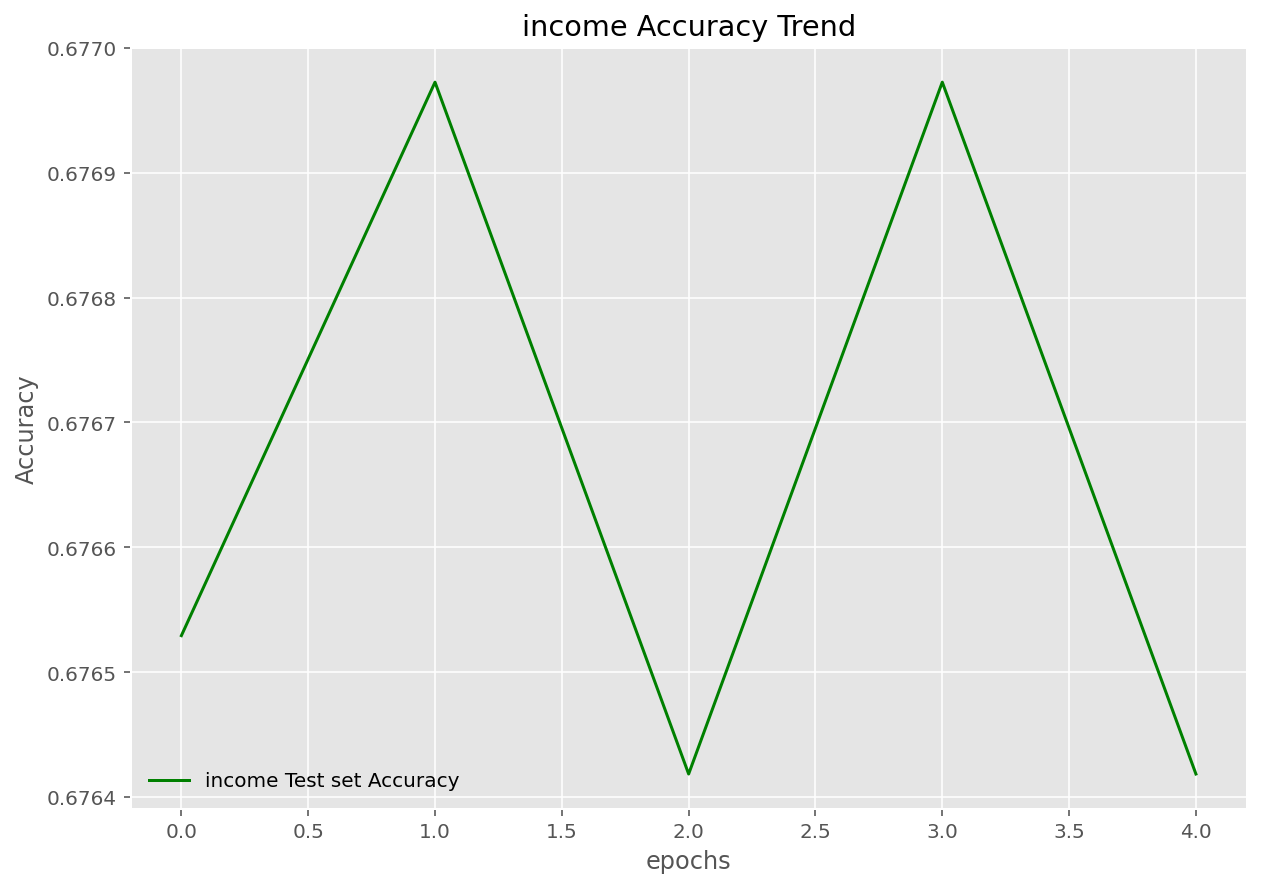

In [3088]:
plt.figure(figsize=(10,7))
plt.title("income Accuracy Trend")
plt.plot(test_y1_acc, color='green', label='income Test set Accuracy')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.savefig(utl_saving_path + "accuracy_test_plot.png")
plt.show()

In [3089]:
# Adversary Model
class AdvModel(nn.Module):
    def __init__(self, ngpu):
        super(AdvModel, self).__init__()
        self.ngpu = ngpu
        
        # input is 102
        # classifier: (gender)
        self.fllc1 = nn.Linear(102, 256)
        self.actv1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fllc2 = nn.Linear(256, 256)
        self.actv2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fllc3 = nn.Linear(256, 128)
        self.actv3 = nn.ReLU(inplace=True)
        self.dropout3 = nn.Dropout(p=0.4)
        self.fllc4 = nn.Linear(128, 2)
        self.actv4 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        y1 = self.fllc1(x)
        y1 = self.actv1(y1)
        y1 = self.dropout1(y1)
        y1 = self.fllc2(y1)
        y1 = self.actv2(y1)
        y1 = self.dropout2(y1)
        y1 = self.fllc3(y1)
        y1 = self.actv3(y1)
        y1 = self.dropout3(y1)
        y1 = self.fllc4(y1)
        y1 = self.actv4(y1)
        return y1


In [3090]:
# Create the ADV
adversaryModel = AdvModel(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    adversaryModel = nn.DataParallel(adversaryModel, list(range(ngpu)))

adv_load = load_model(adv_model_path, 'adv', adv_model_number, adversaryModel, device)

In [3091]:
# Calc Accuracy for adversary
def calcAdvAccuracyTest(model, test_loader):
    model.to(device)
    print("Calculating Accuracy...")
    model.eval()
    y1_accuracy = 0
    prog_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    with torch.no_grad():
        for i, data in prog_bar:
            inputs, labels = data[0], data[1]
            # added:
            labels = extract_class_index(labels)
            # inputs, labels = inputs.to(torch.float32), labels.to(torch.float32)
            inputs = inputs.to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)
            # a1, label_top_class = labels.topk(1, dim=1)
            output = model(inputs)
            ps_y1 = torch.exp(output)
            top_p_y1, top_class_y1 = ps_y1.topk(1, dim=1)
            # equals_y1 = top_class_y1 == label_top_class.view(*top_class_y1.shape)
            equals_y1 = top_class_y1 == labels.view(*top_class_y1.shape)
            acc_y1 = equals_y1.sum().item()
            y1_accuracy += (acc_y1 / len(equals_y1))            
    y1_accuracy = y1_accuracy / len(test_loader)
    return y1_accuracy

In [3092]:
# For Adversary
# Test on obfuscated data
adversaryModel.to(device)
gender_accuracy = calcAdvAccuracyTest(adversaryModel, utl_test_loader)
print(f"\n Adversary Gender Accuracy on Testset: {gender_accuracy:.6f}")

Calculating Accuracy...


100%|██████████| 141/141 [00:00<00:00, 274.23it/s]


 Adversary Gender Accuracy on Testset: 0.607380


In [3093]:
gender_accuracy

0.6073803191489362

In [3094]:
import operator
indexed = list(enumerate(test_y1_acc))
top_30 = sorted(indexed, key=operator.itemgetter(1))[-30:]
print(list(reversed([i for i, v in top_30])))
print(list(reversed([v for i, v in top_30])))

[3, 1, 0, 4, 2]
[0.6769725177304965, 0.6769725177304965, 0.676529255319149, 0.6764184397163121, 0.6764184397163121]
